# Rebuttal Tasks asked by Reviewers

In [1]:
from misc.save_files import *
import os, sys, re, enchant, logging
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
logger = logging.getLogger()
from Keywords.special_terms import extract_abbreviations, extract_medical_terms, extract_disease_terms

from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from nltk.util import ngrams

from misc.counter import count_dict_three_level
import copy

from gensim.models import TfidfModel
from gensim import corpora
import matplotlib
from misc.abb_med_disease import gen_abb_med_disease



## Setup Locations & Parameters
target_path: should contain 
 - {Query Phrase}_dataset.pkl # all small characters and whitespaces replaced with "_"
 - {Associated Disease}_dataset.pkl # all small characters and whitespaces replaced with "_"


In [2]:
target_path = "C:\\Users\\non-admin\\OneDrive - Charité - Universitätsmedizin Berlin\\Rebuttal PLOS Comput Biol\\Files for Dataverse Upload\\New_Data_Crawl_2024_07_11"
os.makedirs(target_path, exist_ok=True)
USAN_Stems_file = "C:\\Users\\non-admin\\Documents\PyCharm\\PubDigest\\base_data\\USAN_Stems.csv"
query_phrase="chronic_thromboembolic_pulmonary_hypertension"
associated_disease="venous_thrombosis"

## Read in Data

In [3]:
query_phrase = query_phrase.replace(" ", "_").lower()
associated_disease = associated_disease.replace(" ", "_").lower()

df_query = read_pickle(path=os.path.join(target_path, f"{query_phrase}_dataset.pkl"), logger=logger)


df_associated_disease = read_pickle(path=os.path.join(target_path, f"{associated_disease}_dataset.pkl"), logger=logger)

In [4]:
print(df_query.shape[0], df_associated_disease.shape[0])

3614 82267


In [5]:
term_list = df_query["clean_text"].tolist()
len([True for i in term_list if len(i) > 0])

3614

In [6]:
term_list = df_associated_disease["clean_text"].tolist()
len([True for i in term_list if len(i) > 0])

82260

Save Dataset as Excel File

In [7]:
if not os.path.isfile(os.path.join(target_path, f"{query_phrase}_dataset.xlsx")):
    df_query.sort_values(by=["publication year", "publication month", "publication day"], ascending=False).to_excel(os.path.join(target_path, f"{query_phrase}_dataset.xlsx"))
if not os.path.isfile(os.path.join(target_path, f"{associated_disease}_dataset.xlsx")):
    df_associated_disease.sort_values(by=["publication year", "publication month", "publication day"], ascending=False).to_excel(os.path.join(target_path, f"{associated_disease}_dataset.xlsx"))

## Analyze Special Terms
  - Drug Terms
  - Clinical Features

In [8]:
def extract_medical_terms_USAN(document_text_list: list, USAN_Stems):
    """
    :param document_text_list: list -> corpus_list[document_1_list[term_1, term_2, ... term_n], document_2_list[term_1, term_2, ... term_n], ..., document_n_list[term_1, term_2, ... term_n]]
    :return:
    """
    df_drug_stems = pd.read_csv(USAN_Stems)
    df_drug_stems["prefix"] = df_drug_stems.apply(lambda x: True if x["Stems"][0] != "-" and x["Stems"][-1] == "-" else False, axis=1)
    df_drug_stems["suffix"] = df_drug_stems.apply(lambda x: True if x["Stems"][0] == "-" and x["Stems"][-1] != "-" else False, axis=1)
    df_drug_stems["infix"] = df_drug_stems.apply(lambda x: True if x["Stems"][0] == "-" and x["Stems"][-1] == "-" else False, axis=1)
    df_drug_stems["just_stem"] = df_drug_stems.apply(lambda x:  x["Stems"].strip("-"), axis=1)
    df_drug_stems["error"] = df_drug_stems.apply(lambda x: False if x["prefix"] or x["suffix"] or x["infix"] else True, axis=1)
    # med_dict = dict(df_med["Synonyms"])
    prefix_set = set(df_drug_stems[df_drug_stems["prefix"]]["just_stem"])
    prefix_len_set = set(len(i) for i in prefix_set)
    suffix_set = set(df_drug_stems[df_drug_stems["suffix"]]["just_stem"])
    suffix_len_set = set(len(i) for i in suffix_set)
    infix_set = set(df_drug_stems[df_drug_stems["infix"]]["just_stem"])
    infix_len_set = set(len(i) for i in infix_set)
    med_terms = [[term for term in doc
                         if any(True for i in suffix_len_set
                                if len(term) > i and term[-i:] in suffix_set)
                         or any(True for i in prefix_len_set
                                if len(term) > i and term[:i] in prefix_set)
                         or any(True for i in infix_len_set
                                for j in range(len(term))
                                if len(term[j+1:-1]) > i and term[j+1:j+1+i]) in infix_set]
                        for doc in document_text_list]
    d = enchant.Dict("en_US")
    med_terms = [[term for term in doc if not d.check(term)] for doc in med_terms]
    return set([j for i in med_terms for j in i])

In [9]:
document_text_list=df_query["clean_text"].tolist()
usan_set = extract_medical_terms_USAN(document_text_list=document_text_list, USAN_Stems=USAN_Stems_file)
usan_set_cteph = usan_set
usan_set_vt = extract_medical_terms_USAN(document_text_list=df_associated_disease["clean_text"].tolist(), USAN_Stems=USAN_Stems_file)

In [10]:
df_chembl_drugs = pd.read_csv("C:\\Users\\non-admin\\Documents\\PyCharm\\PubMedCrawler\\base_data\\CHEMBL_medication_names.csv") # Requires manual download from ChEMBL + preprocessing by misc/prepCHEMBL.py
chembl_set = set([j for i in document_text_list for j in i]).intersection(set(df_chembl_drugs["Synonyms"]))

In [11]:
print("USAN unique terms:", len(usan_set))
print("ChEMBL unique terms:", len(chembl_set))

USAN unique terms: 234
ChEMBL unique terms: 130


In [12]:
def mean_std_counts(term_list, group, prefix, dataset_category):
    term_length = [len(i) for i in term_list]
    term_length_unique = [len(set(i)) for i in term_list]
    term_length_non_zero = [len(i) for i in term_list if len(i) > 0]
    term_length_non_zero_unique = [len(set(i)) for i in term_list if len(i) > 0]
    dict_list = []
    print(group, prefix, dataset_category, min(term_length_non_zero), np.mean(term_length_non_zero), max(term_length_non_zero))
    for term_list_temp, term_list_name in zip([term_length, term_length_unique, term_length_non_zero, term_length_non_zero_unique], ["All Terms",  "Unique Terms", "All Terms\nNo Empty Abstract", "Unique Terms\nNo Empty Abstract"]):
        dict_list.append({"Dataset Category": dataset_category, "Dataset Name": prefix, 
                     "Term Group": group,
                     "Filtering": term_list_name,
                     "# Terms": len(term_list_temp),
                     "Mean length": np.mean(term_list_temp),
                     "standard deviation": np.std(term_list_temp),
                          "#Terms per Abstract": term_list_temp})
        
    # print("Term_length length:", len(term_length), "Term_length mean:", np.mean(term_length),"Term_length std:", np.std(term_length))
    # print("Term_length length:", len(term_length_unique), "Term_length unique mean:", np.mean(term_length_unique),"Term_length unique std:", np.std(term_length_unique))
    # print("Term_length length:", len(term_length_non_zero), "Term_length non zero mean:", np.mean(term_length_non_zero),"Term_length non zero std:", np.std(term_length_non_zero))
    # print("Term_length length:", len(term_length_non_zero_unique), "Term_length non zero unique mean:", np.mean(term_length_non_zero_unique),"Term_length non zero unique std:", np.std(term_length_non_zero_unique))


    # df_temp = pd.DataFrame(data={"All Terms": term_length, "Unique Term length": term_length_unique})
    # df_temp_non_zero = pd.DataFrame(data={"All Terms - No Zero Counts": term_length_non_zero, "Unique Term length - No Zero Counts": term_length_non_zero_unique})
    # df_temp_melt = df_temp.melt(var_name="Subset", value_name="Document Term Count")
    # df_temp_melt_non_zero = df_temp_non_zero.melt(var_name="Subset", value_name="Document Term Count")
    # df_plotting = pd.concat([df_temp_melt, df_temp_melt_non_zero])
    # ax = sns.violinplot(data=df_plotting, x="Subset", y="Document Term Count", density_norm="count", width=1.5)
    # plt.xticks(rotation=90)
    # # ax = sns.scatterplot(data=df_temp_melt, x_jitter=1, hue="Subset", x="Subset", y="Document Term Count", legend=False)
    # plt.title(group)
    # plt.tight_layout()
    # plt.savefig(os.path.join(target_path, f"{prefix}_{group}_Term_length.png"), dpi=400)
    # plt.show()
    # plt.clf()
    return dict_list

### Query Phrase

In [13]:
drug_list_list = df_query["medical_terms_clean_text"].tolist()
used_drug_terms = {j for i in drug_list_list for j in i}
# secondary filtering:     
# "medicalterms_to_ignore_suffix": ["ase", "pathy", "thoracic", "graphy", "pathic"],

print(usan_set.difference(used_drug_terms))

{'b--urokinase', 'oxidoreductase', 'antielastase', 'transaminase', 'transcriptase-polymerase', 'non-cardiothoracic', 'intrathoracic', 'caspase', 'hs-tnt-increase', 'synthase', 'transpeptidase', 'clase', 'myeloperoxidase', 'bulgaria-case', 'staphylokinase', 'elastase', 'hydrolase', 'arteriopathy', 'metalloproteinase', 'NTM-disease', 'anistreplase', 'guanylate-cyclase', 'synthetase', 'arteriopathic', 'urokinase', 'exonuclease', 'tenecteplase', 'a--urokinase', 'ciclase', 'hs-tnt-decrease', 'alteplase', 'cardiothoracic', 'embase', 'april', 'deacetylase', 'starBase', 'cyclase', 'arteriography', 'arteriolopathy', 'dismutase', 'transthoracic', 'anhydrase', 'aminotransferase', 'reteplase', 'heparanase', 'saruplase'}


In [14]:
term_length_dict_list = []

In [15]:
term_list = df_query["clean_text"].tolist()
drug_list_list = df_query["medical_terms_clean_text"].tolist()
disease_list_list = df_query["disease_terms_clean_text"].tolist()

print("Drug Compounds", "Unique:", len({j for i in drug_list_list for j in i}))
term_length_dict_list.extend(mean_std_counts(drug_list_list, group="Drug Compound", prefix=query_phrase, dataset_category="Query Phrase"))
print("disease terms", "Unique:", len({j for i in disease_list_list for j in i}))
term_length_dict_list.extend(mean_std_counts(disease_list_list, group="Clinical Feature", prefix=query_phrase, dataset_category="Query Phrase"))
drug_terms = {j for i in drug_list_list for j in i}
clinical_Feature_terms = {j for i in disease_list_list for j in i}
df_special_terms = pd.DataFrame(data={"Term Category": [*["Drug Compound Terms" for i in drug_terms],
                                                         *["Clinical Feature Terms" for i in clinical_Feature_terms]],
                                   "Term": [*drug_terms, *clinical_Feature_terms]})
df_special_terms.to_csv(os.path.join(target_path, f"{query_phrase}_Special_Terms.tsv"), decimal=",", sep="\t")

Drug Compounds Unique: 188
Drug Compound chronic_thromboembolic_pulmonary_hypertension Query Phrase 1 4.738434163701068 43
disease terms Unique: 330
Clinical Feature chronic_thromboembolic_pulmonary_hypertension Query Phrase 1 3.097560975609756 28


### Associated Disease

In [16]:
term_list = df_associated_disease["clean_text"].tolist()
drug_list_list = df_associated_disease["medical_terms_clean_text"].tolist()
disease_list_list = df_associated_disease["disease_terms_clean_text"].tolist()

print("Drug Compounds",  "Unique:", len({j for i in drug_list_list for j in i}))
term_length_dict_list.extend(mean_std_counts(drug_list_list, group="Drug Compound", prefix=associated_disease, dataset_category="Associated Disease"))
print("disease terms",  "Unique:", len({j for i in disease_list_list for j in i}))
term_length_dict_list.extend(mean_std_counts(disease_list_list, group="Clinical Feature", prefix=associated_disease, dataset_category="Associated Disease"))
drug_terms = {j for i in drug_list_list for j in i}
clinical_Feature_terms = {j for i in disease_list_list for j in i}
df_special_terms = pd.DataFrame(data={"Term Category": [*["Drug Compound Terms" for i in drug_terms],
                                                         *["Clinical Feature Terms" for i in clinical_Feature_terms]],
                                   "Term": [*drug_terms, *clinical_Feature_terms]})
df_special_terms.to_csv(os.path.join(target_path, f"{associated_disease}_Special_Terms.tsv"), decimal=",", sep="\t")

Drug Compounds Unique: 2197
Drug Compound venous_thrombosis Associated Disease 1 3.9526770040959627 70
disease terms Unique: 2343
Clinical Feature venous_thrombosis Associated Disease 1 4.168294604760418 94


In [17]:
df_term_length_distribution = pd.DataFrame(term_length_dict_list)
df_term_length_distribution[[i for i in df_term_length_distribution.columns 
                                                         if i != "#Terms per Abstract"]].to_csv(os.path.join(target_path, "Abstract_Term_length_distribution.tsv"), decimal=",", sep="\t")

In [18]:
df_melt_explode = df_term_length_distribution.explode(column="#Terms per Abstract")
# df_melt_explode = df_term_length_distribution[df_term_length_distribution["Dataset Category"]== "Query Phrase"].explode(column="term length vector")
df_melt_explode["#Terms per Abstract"] = pd.to_numeric(df_melt_explode["#Terms per Abstract"])

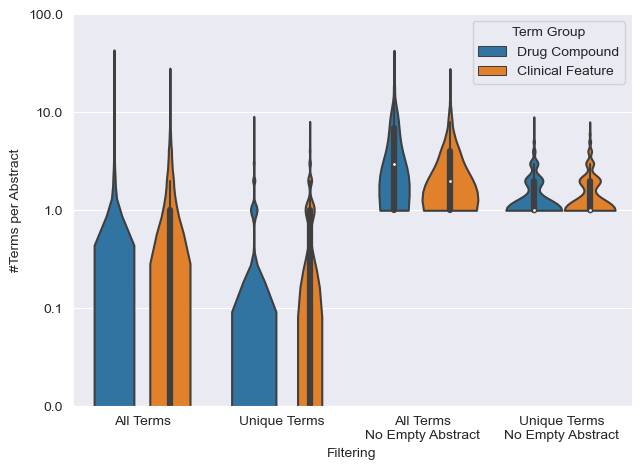

<Figure size 640x480 with 0 Axes>

In [19]:
ax = sns.violinplot(data=df_melt_explode[df_melt_explode["Dataset Name"]==query_phrase], #kind="violin", margine_titles=True, 
                    hue="Term Group", split=False, cut=False,
                    x="Filtering", y="#Terms per Abstract", density_norm="count")
plt.ylim(0, 10**2)

# plt.grid("minor")
plt.tight_layout()

plt.savefig(os.path.join(target_path, f"{query_phrase}_Abstract_Term_length_distributions.png"), dpi=400)

plt.ylim(10**-2, 10**2)
plt.gca().set_yscale("log")
# plt.yscale("log")
plt.gca().get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.savefig(os.path.join(target_path, f"{query_phrase}_Abstract_Term_length_distributions_logy.png"), dpi=400)


plt.show()
plt.clf()

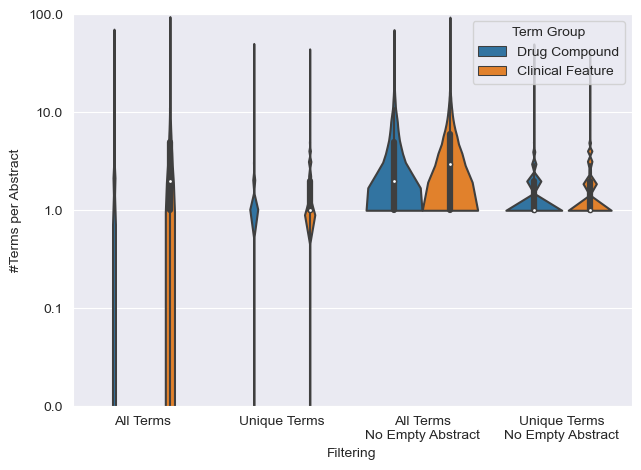

<Figure size 640x480 with 0 Axes>

In [20]:
ax = sns.violinplot(data=df_melt_explode[df_melt_explode["Dataset Name"]==associated_disease], #kind="violin", margine_titles=True, 
                    hue="Term Group", split=False, cut=False,
                    x="Filtering", y="#Terms per Abstract", density_norm="count")
plt.ylim(0, 10**2)

# plt.grid("minor")
plt.tight_layout()

plt.savefig(os.path.join(target_path, f"{associated_disease}_Abstract_Term_length_distributions.png"), dpi=400)

plt.ylim(10**-2, 10**2)
plt.gca().set_yscale("log")
# plt.yscale("log")
plt.gca().get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

plt.savefig(os.path.join(target_path, f"{associated_disease}_Abstract_Term_length_distributions_logy.png"), dpi=400)


plt.show()
plt.clf()

In [21]:
# ax = sns.catplot(data=df_melt_explode, kind="violin", col="Dataset Name", margine_titles=True, 
#                  bw_method="scott",
#                     hue="Term Group", split=True, cut=True,
#                     x="Filtering", y="term length vector", density_norm="count")
# plt.ylim(0, 18)
# plt.tight_layout()
# plt.savefig(os.path.join(target_path, f"Abstract_Term_length_distributions_cutoff.png"), dpi=400)
# plt.show()
# plt.clf()

## TF-IDFs
Filter and Sort TF-IDFs as per user specs

In [22]:
def sort_tfidf(df_tfidf):
    column_list = [*sorted([i for i in df_tfidf.columns if i not in ["avg", "idf", "sum"]]),
               "idf", "TF_Corpus"]
    column_list.append("TF-IDF")
    df_tfidf = df_tfidf.assign(TF_Corpus=df_tfidf["sum"] / df_tfidf["idf"])
    df_tfidf = df_tfidf.rename(columns={"sum": "TF-IDF"})
    df_tfidf = df_tfidf[column_list]
    df_tfidf = df_tfidf.sort_values(by="TF-IDF", ascending=False)
    return df_tfidf

In [23]:
disease_terms_to_ignore = {"diagnosis", "prognosis", "misdiagnosis", "analysis", "basis",
                              "meta-analysis", "ontology", "doagra", "angiogram", "hypothesis", "program", "synthesis",
                              "poor-prognosis"}
medicalterms_to_ignore_suffix= {"ase", "pathy", "thoracic", "graphy", "pathic"}
medicalterms_to_ignore= ["april"]
def filter_medical_terms(document_text_list: list, ignore_terms, ignore_term_suffix):

    document_text_list = [[term for term in doc if not term in ignore_terms] for doc in document_text_list]
    document_text_list = [[term for term in doc
                  if not any(i == term[-len(i):] for i in ignore_term_suffix)]
                 for doc in document_text_list]
    return document_text_list

In [24]:
df_tfidf_disease = read_pickle(os.path.join(target_path, f"{query_phrase}_tfidf_1_gram_disease_filterable.pkl"),
                               logger=logger)
df_tfidf_disease = df_tfidf_disease[~df_tfidf_disease.index.isin(disease_terms_to_ignore)]
df_tfidf_disease = sort_tfidf(df_tfidf=df_tfidf_disease)
df_tfidf_disease.to_csv(os.path.join(target_path, f"{query_phrase}_TF_IDF_Clinical_Features.tsv"), decimal=",", sep="\t")


df_tfidf_drugs = read_pickle(os.path.join(target_path, f"{query_phrase}_tfidf_1_gram_med_filterable.pkl"),
                               logger=logger)
terms_to_keep = filter_medical_terms(document_text_list=df_tfidf_drugs.index.tolist(), ignore_terms=medicalterms_to_ignore, ignore_term_suffix=medicalterms_to_ignore_suffix)
df_tfidf_drugs = sort_tfidf(df_tfidf=df_tfidf_drugs)
df_tfidf_drugs.to_csv(os.path.join(target_path, f"{query_phrase}_TF_IDF_Drugs.tsv"), decimal=",", sep="\t")

## Identify Disease Terms

In [25]:
# <editor-fold desc="Identify Disease Terms">
def identify_possible_diseases(document_text_list: list, terms_of_interest: set, terms_of_uninterest: set, minimum_naming=5):


    ngram_list = [[[" ".join([i for i in ngram]) for ngram in ngrams(sequence=doc, n=n)] for doc in document_text_list] for n in
                  [2, 3, 4, 5]]
    c_dict = count_dict_three_level(ngram_list)
    c_dict = {k: v for k, v in c_dict.items() if v > minimum_naming and any(True if term in k else False for term in terms_of_interest) and not any(True if term in k else False for term in terms_of_uninterest)}
    new_dict = {}
    for k, v in c_dict.items():

        dict_of_duplicates = {key: val for key, val in c_dict.items() if (k in key or key in k) and k != key}
        if not any(v < dup_val for dup_val in dict_of_duplicates.values()):
            new_dict[k] = v

    df_disease_count = pd.DataFrame(data={"disease name": new_dict.keys(), "term count": new_dict.values()})
    return df_disease_count





terms_of_interest_top10 = set(df_tfidf_disease.index.tolist()[:10])
terms_of_uninterest={"have", "be", "use", "may", "not", "diagnosis", "prognosis", "misdiagnosis", "analysis", "basis",
                          "meta-analysis", "ontology", "doagra", "angiogram", "hypothesis", "program", "synthesis", "poor-prognosis"}

df_disease_counts_top10 = identify_possible_diseases(df_query["clean_text"].tolist(), terms_of_interest=terms_of_interest_top10,
                                                     terms_of_uninterest=terms_of_uninterest)
df_disease_counts_top10 = df_disease_counts_top10.sort_values(by=["term count"], ascending=False)

df_disease_counts_all = identify_possible_diseases(df_query["clean_text"].tolist(), terms_of_interest=set(df_tfidf_disease.index),
                                                     terms_of_uninterest=terms_of_uninterest)
df_disease_counts_all = df_disease_counts_all.sort_values(by=["term count"], ascending=False)

df_disease_counts_top10.sort_values(by=["term count"], ascending=False).to_csv(os.path.join(target_path, f"{query_phrase}_Disease_names_counts_top10_clinical_features.tsv"), decimal=",", sep="\t")
df_disease_counts_all.sort_values(by=["term count"], ascending=False).to_csv(os.path.join(target_path, f"{query_phrase}_Disease_names_counts_ALL_clinical_features.tsv"), decimal=",", sep="\t")
# </editor-fold>


## Annotation of Predicted indirect Terms

In [26]:
keyed_vector = read_pickle(os.path.join(target_path, "joined_skip-gram_model_CTEPH_VT_w2v_2024.kv"), logger=logger)
base_term = "CTEPH"
top_prediction_terms = len(keyed_vector.index2entity)
most_similar_terms = keyed_vector.most_similar(positive=[base_term], topn=top_prediction_terms)
df_most_similar_terms = pd.DataFrame(data={"drug compound": [i[0] for i in most_similar_terms],
                                              "cosine_similarity": [i[1] for i in most_similar_terms]})


In [27]:
anti_thrombotic_drugs = {# from previously compiled list
                                   "caplacizumab", "benzarone", "enalaprilat", "trental", "mechlorethamine", "androgel",
                                  # https://www.drugs.com/drug-class/thrombolytics.html#
                                  "streptodornase", "vorapaxar", "abciximab", "eptifibatide", "tirofiban", "streptokinase",
                                  "alteplase", "tenecteplase", "reteplase", "urokinase", "streptase", "kinlytic", #"abbokinase",
                                   # https://www.drugs.com/drug-class/thrombin-inhibitors.html
                                  "dabigatran", "bivalirudin", "desirudin",
                                   # https://www.drugs.com/drug-class/heparins.html
                                   "enoxaparin", "delteparin", "tinzaparin", " danaparoid",
                                   # https://www.drugs.com/drug-class/factor-xa-inhibitors.html
                                   "apixaban", "fondaparinux", "rivaroxaban", "edoxaban", "betrixaban",
                                   # https://www.drugs.com/drug-class/coumarins-and-indandiones.html
                                   "warfarin",
                                   # https://www.drugs.com/drug-class/antiplatelet-agents.html
                                 "aspirin", "cangrelor", "cilostazol", "clopidogrel", "dipyridamole", "prasugrel", "ticlopidine", "ticagrelo"}
pro_thrombotic_drugs = {# from a compiled list
                                   "carfilzomib", "etanercept",  "olmesartan", "olanzapine", "ponatinib", "levaminsol",
                                 # https://link.springer.com/article/10.1007/s40264-013-0054-6/tables/1
                                   "ciclosporin", "5-FU", "bleomycin", "busulfan", "cis-platinum", "doxorubicin",
                                   "gemtuzumab", "asparainase", "l-asparainase", "mitomycin", "paclitaxel", "tamoxifen",
                                   "thalidomide", "bevacizumab", "rofecoxib", "ephedra", "erythropoietin", "heparin",
                                   "ciclosporin", "glucocoricoids", "dexamethasone", "sirolimus", "interferon", "interferon-alpha",
                                   "metformin", "quinine", "escitalopram", "sildenafil", "ticlopidin", "clopidogrel", "tranexamic"
}


not_a_drug = {"arteriomegaly", "calciphylaxis", "troponin-i", "arterially", "sP-selectin", "virginia", "calpastatin"
              "predilution", "intra-cardiac", "arteriolosclerotic", "arteriopathy", "rac", "prediabetes", "arteriographically",
              "deiminase", "bitistatin", "metavir", "cyclase", "elastase", "nonstatin","arteriopathic", "virologic",
              "algerian", "gly197", "arterioarterial","femoro-iliac", "serpine", "pre-menopausal", "alpha-galactosidase",
              "somali", "transthoracic", "gadofosveset-enhanced", "calprotectin", "coeliac", "belfast", "on-oac",
              "non-edoxaban", "philippine", "somalia",  'biermer', 'gondar', 'BRAF-mutant',  'bulgarian', 'glioblastoma-related', 'hungarian',
              'prediagnosis',  'iowa', 'extracardiac','predesigned', 'ultrafast', 'jordan', 'faisal', 'guangzhou', 'nonhemophiliac',
              "arteriopathy",  "troponins", "somalia", 
              "arteriopathic", "cyclase", "guanylate", "bulgarian", "myofibroblast", "neopterin", 
"deacetylase", "prediagnosis",'selectin',
              'april','alzheimer', 'austrian','guanosine', 'nigerian', 'non-doac','virchow', 'propeptide','nonheparin',
        'arteriogram', 'arteriography', 'arteriopathies', 'deux', 'noncardiac', 'noncontrast', 'postcontrast', 'predischarge',
        'submucosal', 'synthase', 'synthetase', 'transcriptase-polymerase', 'transpeptidase', 'trophoblastic', 'immer',
        'saruplase','transaminase', 'staphylokinase', 'hydrolase','metalloproteinase','myeloperoxidase','exonuclease','heparanase',
        'embase', 'dismutase','caspase','aminotransferase', 'anhydrase'





}


other_drugs = {"ruxolitinib": "fibrosis", "fasudil": "hemorrhage",
               "imatinib": "cancer", "filgotinib": "artritis",
               "gatifloxacin": "anti_bacterial", "ixekizumab": "auto_immune",
               "ranibizumab":"retinal vein occlusion", "diltiazem": "angia",
               "aflibercept": "retinal vein occlusion", "sorafenib": "cancer",
               "dydrogesterone": "menstrual cycle", "lasofoxifene": "osteoporosis", "tolvaptan": "hyponatremia",
               'alpelisib': "NA", 'sofosbuvir': "NA", 'lasofoxifene': "NA", 'neopterin': "NA", 'AngioVac': "NA", 
               'rifamycins': "NA", 'phloretin': "NA", '99mTc-apcitide': "NA", 'alirocumab': "NA",'selectin': "NA",
               'omalizumab': "NA", 'diltiazem': "NA", 'lectin': "NA", 'aviptadil': "NA", 'dupilumab': "NA", 'romidepsin': "NA",
               'vaspin': "NA",'beta-sitosterol': "NA"
               }





In [28]:
known_terms_vt = {j for i in df_associated_disease["clean_text"].tolist() for j in i if j == "calcilytic"}


In [29]:
df_retrospective_validation = read_pickle(path="C:\\Users\\non-admin\\Documents\\PyCharm\\PubDigest\\data\\chronic thromboembolic pulmonary hypertension\\Data_for_Plotting\\Embedding\\specific_term_validation_skip-gram_CTEPH_venous thrombosis.pkl", logger=logger)
set(df_retrospective_validation["query_term"])

{'abciximab',
 'abiraterone',
 'acenocumarol',
 'acetazolamide',
 'adiponectin',
 'alteplase',
 'ambrisentan',
 'androgel',
 'anti-cardiolipin',
 'anticardiolipin',
 'apixaban',
 'armamentarium',
 'arteriais',
 'arteriosus',
 'aspirin',
 'atorvastatin',
 'aviptadil',
 'azithromycin',
 'baricitinib',
 'benzarone',
 'beraprost',
 'betrixaban',
 'bevacizumab',
 'bivalirudin',
 'bleomycin',
 'bosentan',
 'busulfan',
 'calcilytic',
 'calciparin',
 'cangrelor',
 'caplacizumab',
 'cardiolipin',
 'cardiothoracic',
 'carfilzomib',
 'ceftriaxone',
 'chemoattractant',
 'chylopericardium',
 'ciclosporin',
 'cilostazol',
 'cis-platinum',
 'cisplatin',
 'clarithromycin',
 'clopidogrel',
 'cyproterone',
 'dabigatran',
 'darbepoetin',
 'delteparin',
 'desirudin',
 'dexamethasone',
 'digoxin',
 'diltiazem',
 'dipyridamole',
 'doxorubicin',
 'doxycycline',
 'e-selectin',
 'eculizumab',
 'edoxaban',
 'enalaprilat',
 'endostatin',
 'enoxaparin',
 'epoetin',
 'eptifibatide',
 'erythropoietin',
 'escitalopr

In [30]:
df_retrospective_validation[df_retrospective_validation["query_term"]=="bosentan"]

,year,base_term,query_term,similarity,co_occurrence
30,2024,CTEPH,bosentan,0.424565,1
31,before_prediction,CTEPH,bosentan,NaN,32


In [31]:
df_coocurence = read_pickle("C:\\Users\\non-admin\\Documents\\PyCharm\\PubDigest\\data\\chronic thromboembolic pulmonary hypertension\\Data_for_Plotting\\Embedding\\venous thrombosis\\Prediction_Term_Overlap_specific_term_validation.pkl", logger=logger)

In [32]:
df_coocurence.head()

,VT,CTEPH
Term,,
apixaban,True,True
olmesartan,True,False
ambrisentan,False,True
methylprednisolone,True,True
ruxolitinib,True,True


In [33]:
drug_terms = {*usan_set_cteph, *usan_set_vt}
terms_to_keep = {base_term, *drug_terms, *pro_thrombotic_drugs, *anti_thrombotic_drugs}
df_most_similar_terms = df_most_similar_terms[df_most_similar_terms["drug compound"].isin(terms_to_keep)]
known_terms = {j for i in df_query["clean_text"].tolist() for j in i if j in terms_to_keep}



In [34]:
df_most_similar_terms = df_most_similar_terms.assign(**{"Direct Association":
                                                            df_most_similar_terms.apply(lambda x: x["drug compound"]
                                                                                                  in known_terms, axis=1),
                                                        "Anti-thrombotic drugs":
                                                            df_most_similar_terms.apply(lambda x: x["drug compound"]
                                                                                                  in anti_thrombotic_drugs, axis=1),
                                                        "Pro-thrombotic drugs":
                                                            df_most_similar_terms.apply(lambda x: x["drug compound"]
                                                                                                  in pro_thrombotic_drugs, axis=1),
                                                        "Not a drug":
                                                            df_most_similar_terms.apply(lambda x: x["drug compound"]
                                                                                                  in not_a_drug, axis=1),
                                                        # "Other drugs":
                                                        #     df_most_similar_terms.apply(lambda x: other_drugs.get(x["drug compound"], ""),
                                                        #                                 axis=1),
                                                        # "Other drugs Hit":
                                                        #     df_most_similar_terms.apply(lambda x: x["drug compound"] in other_drugs.keys(),
                                                        #                                 axis=1)
                                                        })

# df_most_similar_terms[~((df_most_similar_terms["Direct Association"]) |
#                         (df_most_similar_terms["Anti-thrombotic drugs"]) |
#                         (df_most_similar_terms["Pro-thrombotic drugs"]) |
#                         (df_most_similar_terms["Not a drug"]) |
#                         (df_most_similar_terms["Other drugs"]))]["drug compound"].tolist()

df_most_similar_terms.to_csv(os.path.join(target_path, "CTEPH_VT_Predicted_Drugs_in_Embedding_Layer_with_Similarity_Annotated_Skip-gram_Model.tsv"), decimal=",", sep="\t")
df_annotation = pd.DataFrame(data={"Thrombotic_Effect": [*["Anti-thrombotic" for i in anti_thrombotic_drugs],
                                                         *["Pro-thrombotic" for i in pro_thrombotic_drugs]],
                                   "Drug Compound": [*anti_thrombotic_drugs, *pro_thrombotic_drugs]})
df_annotation.to_csv(os.path.join(target_path, "Thrombotic_Annotation.tsv"), decimal=",", sep="\t")
# </editor-fold>

In [35]:
len(set(df_most_similar_terms[(df_most_similar_terms["Direct Association"]) & ~((df_most_similar_terms["Anti-thrombotic drugs"]) | (df_most_similar_terms["Pro-thrombotic drugs"]) | (df_most_similar_terms["Not a drug"]))]["drug compound"]))

82

In [36]:
len(set(df_most_similar_terms[~df_most_similar_terms.apply(lambda x:any([x[i] for i in ["Direct Association", "Anti-thrombotic drugs", "Pro-thrombotic drugs", "Not a drug"
                                                                                        ]]), axis=1)]["drug compound"].tolist())) # Not labeled!

615

In [37]:
print("Total Drug Compounds in dataset: ", df_most_similar_terms.shape[0])
print("Not Labeled:", df_most_similar_terms[~df_most_similar_terms.apply(lambda x:any([x[i] for i in ["Direct Association", "Anti-thrombotic drugs", "Pro-thrombotic drugs", #"Other drugs Hit", "Not a drug"
                                                                                                      ]]), axis=1)].shape[0]) # Not labeled!

for i in ["Direct Association", "Anti-thrombotic drugs", "Pro-thrombotic drugs", "Not a drug"]:#,  "Other drugs Hit"]:
    print(i, "Number of Hits:", df_most_similar_terms[df_most_similar_terms[i]].shape[0])
    
for i in [["Direct Association", "Anti-thrombotic drugs"], 
          ["Direct Association", "Pro-thrombotic drugs"], 
          # ["Direct Association","Other drugs Hit"] # have not been labeled!
          ]:
    print(i, "Number of Hits:", df_most_similar_terms[df_most_similar_terms.apply(lambda x:all([x[j] for j in i]), axis=1)].shape[0])

Total Drug Compounds in dataset:  839
Not Labeled: 654
Direct Association Number of Hits: 162
Anti-thrombotic drugs Number of Hits: 28
Pro-thrombotic drugs Number of Hits: 23
Not a drug Number of Hits: 92
['Direct Association', 'Anti-thrombotic drugs'] Number of Hits: 18
['Direct Association', 'Pro-thrombotic drugs'] Number of Hits: 10


In [38]:
df_specific_term_validation_CBOW = read_pickle(os.path.join(target_path, "specific_term_validation_CBOW_CTEPH_venous thrombosis.pkl"), logger=logger)
df_specific_term_validation_CBOW.to_csv(os.path.join(target_path, "specific_term_validation_CBOW_CTEPH_VT.tsv"), decimal=",", sep="\t")

In [39]:
df_specific_term_validation_skip_gram = read_pickle(os.path.join(target_path, "specific_term_validation_skip-gram_CTEPH_venous thrombosis.pkl"), logger=logger)
df_specific_term_validation_skip_gram.to_csv(os.path.join(target_path, "specific_term_validation_skip-gram_CTEPH_VT.tsv"), decimal=",", sep="\t")

## KG analysis - KG Prime

In [41]:
df_kg = pd.read_csv(os.path.join(target_path, "kg.csv"))
df_kg_cetph = df_kg[df_kg["x_name"] == "chronic thromboembolic pulmonary hypertension"]
df_kg_cetph = df_kg[df_kg["y_name"] == "chronic thromboembolic pulmonary hypertension"]
df_kg_cetph.to_csv(os.path.join(target_path, "KG_Prime_kg_CETPH.tsv"), decimal=",", sep="\t")


C:\Users\non-admin\miniforge3\envs\PubDigest\lib\site-packages\IPython\core\interactiveshell.py:3553: DtypeWarning: Columns (3,8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
